In [1]:
!pip install keras-efficientnet-v2

  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 14.8 MB 5.2 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77050 sha256=bdab94368bcd247e8439d48ff1af237698a5a93a0f99bc14a9a16d99c1fb5c76
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator


#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.efficientnet import EfficientNetB7
#from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import keras_efficientnet_v2 

from numpy.random import seed
seed(1)
tf.random.set_seed(1)

import warnings 
warnings.filterwarnings('ignore')

In [3]:
artists = pd.read_csv("../input/best-artworks-of-all-time/artists.csv")

In [4]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [5]:
artists.shape

(50, 8)

In [6]:
artists.isnull().sum()

id             0
name           0
years          0
genre          0
nationality    0
bio            0
wikipedia      0
paintings      0
dtype: int64

In [7]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)
# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [8]:
artists_top.shape

(11, 3)

In [9]:
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [10]:
#Albrecht Dürer in the dataset does not normally look like this. 
#That's why the file can't be read. You can check it by looking at the file information.
#That's why we are chancing this artist name.
artists_top.iloc[4, 0] = "Albrecht Dürer"

**information about OS libraries**

**os.path.join** = it combines one and or more paths

**os.listdir** =  returns a list containing the names of the entries in the directory given by path.

**os.path.exists** = If we have a this path return true.

In [11]:
# Getting main path for read images of the painters.
images_dir = '../input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values
# We are checking to see if there are any problems 
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Not found -->", os.path.join(images_dir, name))

Found --> ../input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> ../input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> ../input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> ../input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> ../input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> ../input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> ../input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> ../input/best-artworks-of-all-time/images/images/Rembrandt
Found --> ../input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> ../input/best-artworks-of-all-time/images/images/Titian
Found --> ../input/best-artworks-of-all-time/images/images/Marc_Chagall


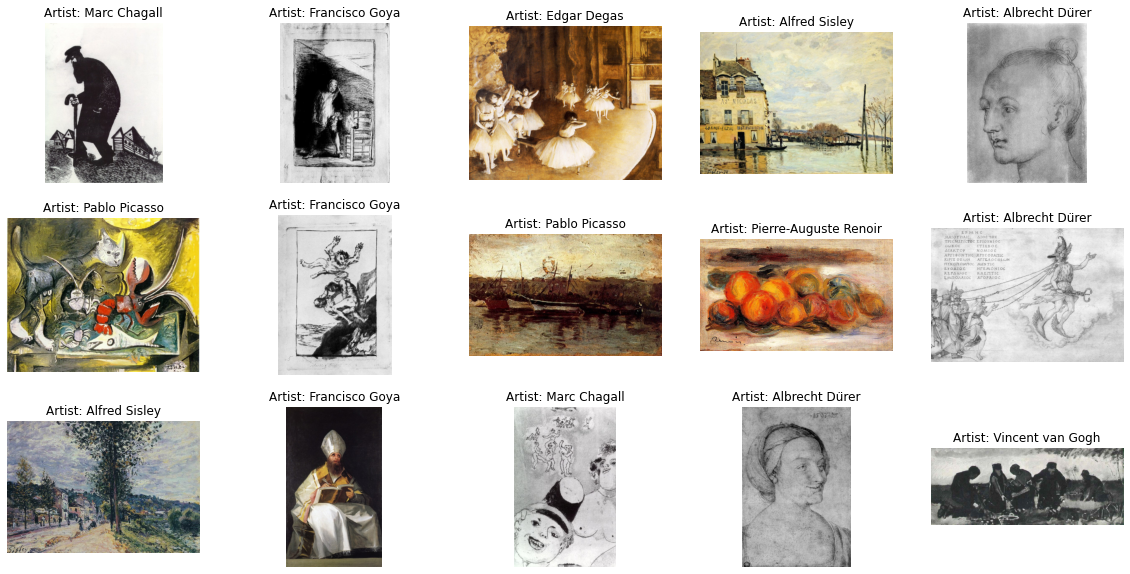

In [12]:
# Print few random paintings
col = 5
row = 3
fig, axes = plt.subplots(row, col, figsize=(20,10))

for i in range(col):
    for j in range(row):
        # Random artist choices.
        random_artist = random.choice(artists_top_name) 
        #selecting a random image of a randomly selected artist
        random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist))) 
        #the resulting paths are being combined.
        random_image_file = os.path.join(images_dir, random_artist, random_image)
        imagee = plt.imread(random_image_file) # Reading image of image path
        axes[j][i].imshow(imagee)
        axes[j][i].set_title("Artist: " + random_artist.replace('_', ' '))
        axes[j][i].axis('off')

plt.show()

In [13]:
imagee.shape

(410, 1024, 3)

**I am trying some things**

In [14]:
resized_image = plt.imread("../input/best-artworks-of-all-time/resized/resized/Albrecht_Du╠êrer_10.jpg")
org_image = plt.imread("../input/best-artworks-of-all-time/images/images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_10.jpg")

In [15]:
resized_image.shape, org_image.shape

((1229, 896), (2048, 1494, 3))

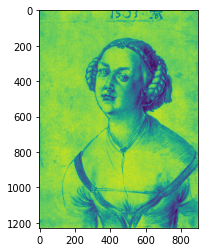

In [16]:
plt.imshow(resized_image)

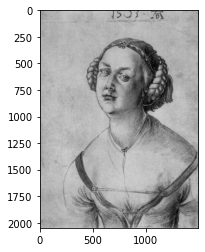

In [17]:
plt.imshow(org_image)

**include_top** = When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained

*Additionally*, when the “include_top” argument is False, the “input_tensor” argument must be specified, allowing the expected fixed-sized input of the model to be changed

**preprocess_input** = Keras works with batches of images. So, the first dimension is used for the number of samples (or images) you have.
When you load a single image, you get the shape of one image, which is (size1,size2,channels).
In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels)
The preprocess_input function is meant to adequate your image to the format the model requires.

In [18]:
inter_op_parallelism_threads = -1
# EfficientNetV2S input shape is 384 by 384
input_shape = (384, 384, 3) 

base_model = keras_efficientnet_v2.EfficientNetV2S(pretrained="imagenet",
                                                   classifier_activation='softmax',
                                                   include_preprocessing=True,
                                                   input_shape=input_shape )
base_model.trainable = True

#(384, 384)

2022-05-08 02:34:34.388036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 02:34:34.527097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 02:34:34.527927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 02:34:34.529076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87859200/87846816 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5


In [19]:
# Augment data
batch_size = 16 # total images / batch size = total augmented data
n_classes = artists_top.shape[0]

datagen = image.ImageDataGenerator(validation_split=0.15,
                                   rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3660 images belonging to 11 classes.
Found 639 images belonging to 11 classes.
Total number of batches = 228 and 39


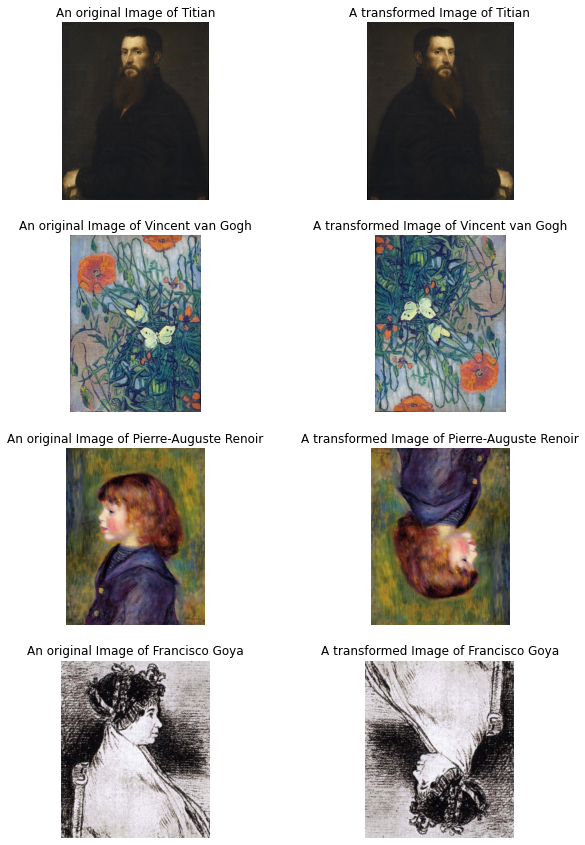

In [20]:
# Print a random paintings and it's random augmented version
col = 2
row = 4

fig, axes = plt.subplots(row, col, figsize=(10,15))


# Original image
for i in range(row):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    
    imagee = plt.imread(random_image_file)
    axes[i][0].imshow(imagee)
    axes[i][0].set_title("An original Image of " + random_artist.replace('_', ' '))
    axes[i][0].axis('off')

    # Transformed image
    aug_image = datagen.random_transform(imagee)
    axes[i][1].imshow(aug_image)
    axes[i][1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
    axes[i][1].axis('off')

plt.show()

In [21]:
base_model.input

<KerasTensor: shape=(None, 384, 384, 3) dtype=float32 (created by layer 'input_1')>

In [22]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.2)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.2)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [23]:
#run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True) options = run_opts
optimizer = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

**EarlyStop hyperparams**

**monitor :** İzlenecek miktar. varsayılan olarak, doğrulama kaybıdır

**min_delta:** İyileştirme olarak nitelendirilmek için izlenen miktarda minimum değişiklik

**patience :** Eğitimin durdurulacağı iyileşme olmayan dönemlerin sayısı.

**mod :** {“otomatik”, “min”, “maks”} seçeneklerinden biri. Bir maksimizasyon problemi mi yoksa bir minimizasyon problemi mi, doğruluğu maksimize ediyoruz, kaybı minimuma indiriyoruz.

**restore_best_weights:** En iyi model ağırlığının mı yoksa son dönem ağırlığının mı kullanılacağı

**ReduceLROnPlateau**

Öğrenme olmuyorken learning_rate i düşürmek için gerekli fonksiyon.

**verbose =** int. 0: quiet, 1: update messages.

**factor =**  factor by which the learning rate will be reduced. new_lr = lr * factor.



In [24]:
n_epoch = 10

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              verbose=1, mode='auto')

In [25]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=-1,
                              class_weight=class_weights
                             )

2022-05-08 02:34:45.734955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-08 02:35:01.792829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


228/228 [==============================] - 173s 665ms/step - loss: 1.8031 - accuracy: 0.3617 - val_loss: 2.3477 - val_accuracy: 0.2788
Epoch 2/10
228/228 [==============================] - 116s 506ms/step - loss: 1.3650 - accuracy: 0.5848 - val_loss: 2.0345 - val_accuracy: 0.4519
Epoch 3/10
228/228 [==============================] - 117s 513ms/step - loss: 1.1084 - accuracy: 0.6828 - val_loss: 1.7256 - val_accuracy: 0.4519
Epoch 4/10
228/228 [==============================] - 116s 507ms/step - loss: 0.9089 - accuracy: 0.7580 - val_loss: 1.6992 - val_accuracy: 0.4407
Epoch 5/10
228/228 [==============================] - 116s 509ms/step - loss: 0.7857 - accuracy: 0.7958 - val_loss: 2.6145 - val_accuracy: 0.2147
Epoch 6/10
228/228 [==============================] - 117s 512ms/step - loss: 0.6958 - accuracy: 0.8093 - val_loss: 1.1021 - val_accuracy: 0.6779
Epoch 7/10
228/228 [==============================] - 116s 508ms/step - loss: 0.7038 - accuracy: 0.7975 - val_loss: 3.1126 - val_accura

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')

In [27]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:70]:
    layer.trainable = True

    
optimizer = Adam(lr=0.00005)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 30
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/30
228/228 [==============================] - 130s 502ms/step - loss: 0.1881 - accuracy: 0.9720 - val_loss: 0.3510 - val_accuracy: 0.8942
Epoch 2/30
228/228 [==============================] - 121s 503ms/step - loss: 0.1685 - accuracy: 0.9756 - val_loss: 0.3289 - val_accuracy: 0.9119
Epoch 3/30
228/228 [==============================] - 121s 506ms/step - loss: 0.1743 - accuracy: 0.9778 - val_loss: 0.3118 - val_accuracy: 0.9119
Epoch 4/30
228/228 [==============================] - 118s 494ms/step - loss: 0.1615 - accuracy: 0.9775 - val_loss: 0.3300 - val_accuracy: 0.9103
Epoch 5/30
228/228 [==============================] - 122s 511ms/step - loss: 0.1583 - accuracy: 0.9802 - val_loss: 0.3215 - val_accuracy: 0.9215
Epoch 6/30
228/228 [==============================] - 117s 488ms/step - loss: 0.1617 - accuracy: 0.9786 - val_loss: 0.3072 - val_accuracy: 0.9167
Epoch 7/30
228/228 [==============================] - 117s 486ms/step - loss: 0.1609 - accuracy: 0.9822 - val_loss: 0.3078 -

In [28]:
model.save("model.h5")

In [29]:
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

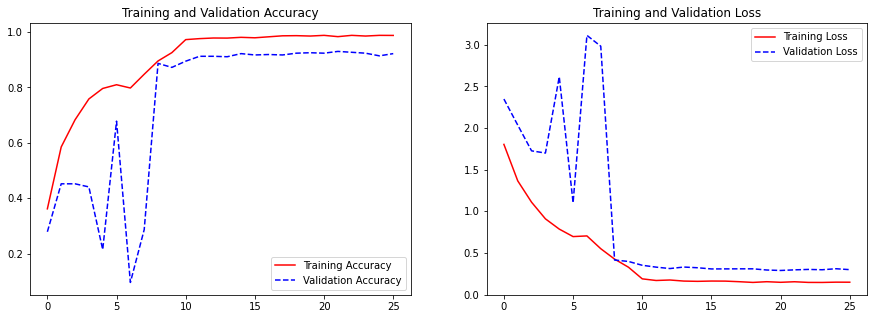

In [30]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [31]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

229/229 [==============================] - 78s 340ms/step - loss: 0.0874 - accuracy: 0.9923
Prediction accuracy on train data = 0.9923497438430786


In [32]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

40/40 [==============================] - 13s 321ms/step - loss: 0.2887 - accuracy: 0.9327
Prediction accuracy on CV data = 0.9327073693275452


In [33]:
tick_labels = artists_top_name.tolist()

def ClassficationReport(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

ClassficationReport(model, valid_generator, STEP_SIZE_VALID)

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.91      0.93      0.92       127
          Edgar_Degas       0.98      0.94      0.96       104
        Pablo_Picasso       0.84      0.94      0.89        63
Pierre-Auguste_Renoir       0.96      0.92      0.94        49
      Albrecht_Dürer       0.96      0.98      0.97        47
         Paul_Gauguin       0.98      0.93      0.95        44
       Francisco_Goya       0.87      0.91      0.89        43
            Rembrandt       0.92      0.89      0.91        38
        Alfred_Sisley       0.93      1.00      0.96        37
               Titian       0.91      0.84      0.87        37
         Marc_Chagall       1.00      0.89      0.94        35

             accuracy                           0.93       624
            macro avg       0.93      0.92      0.93       624
         weighted avg       0.93      0.93      0.93       624



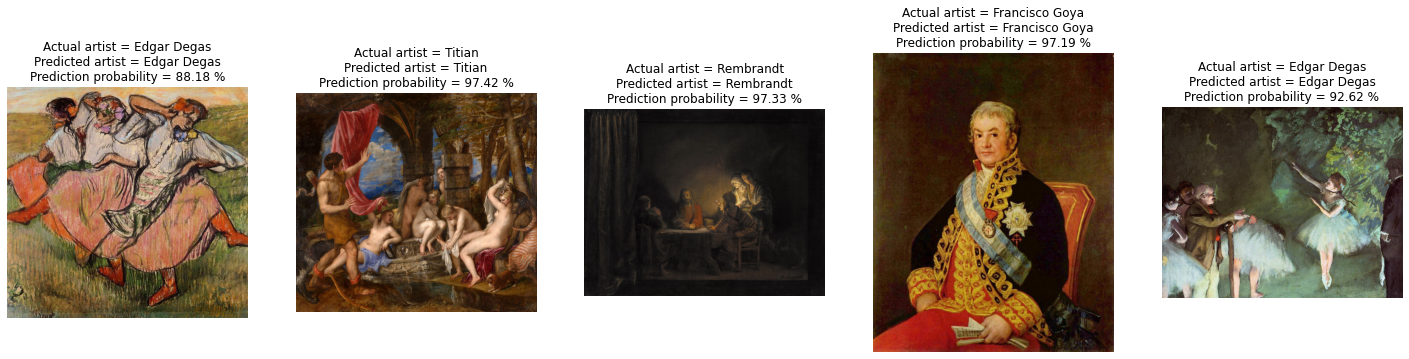

In [34]:
# Prediction

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())


    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), 
                        labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

# **THE END**